# Navier-Stokes Equations

Below follows FEniCS code that solves the Navier-Stokes equations for incompressible flow, for the velocity `u` and pressure `p`, using a stabilized finite element method. If the viscosity `nu` is approximated by zero we get the inviscid Euler equations, characterized by the formation of vortices.

In [1]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *;
from mshr import *;
from IPython.display import display, clear_output;
import time
import logging;
logging.getLogger('FFC').setLevel(logging.WARNING)

In [2]:
# Compact plot utility function
def plot_compact(u, t, stepcounter):
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u,u)), Q);
        ax.cla();
        fig = plt.gcf();
        fig.set_size_inches(16, 2)
        
        # Plot norm of velocity
        plt.subplot(1, 2, 1)
        mplot_function(uEuclidnorm)
        plt.title("Velocity")
        
        if t == 0:
            plt.colorbar()
            plt.axis(G)
            
        plt.subplot(1,2,2)
        
        if t == 0.:
            plt.triplot(mesh2triang(mesh))
            plt.title("Mesh") # plot mesh
        display(pl) # <-- wait wth is `pl`? Ohh, name defined globally..
        
        plt.suptitle("Navier-Stokes t: %f" % (t))
        plt.tight_layout()
        clear_output(wait=True)

### Import Code Starts Here

In [3]:
# Generate domain and mesh
XMIN = 0.
XMAX = 4.
YMIN = 0  # <-- is there a reason int & not float?
YMAX = 1.
G = [XMIN, XMAX, YMIN, YMAX]
eps = 1e-5

In [4]:
mresolution = 30
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), 
                               Point(G[1], G[3])) - Circle(Point(.5, .5), .1),
                     mresolution)

In [5]:
# FEM function spaces and functions
V = VectorFunctionSpace(mesh, "CG", 1)
Q = FunctionSpace(mesh, "CG", 1)
W = V * Q
w = Function(W)
h = CellSize(mesh)
u0 = Function(V)
(v, q) = TestFunctions(W)
(u, p) = (as_vector((w[0], w[1])), w[2])

In [6]:
# Inlet Velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX)

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps)
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)

# Timestep, Viscosity, and Stabilization parameters
k = 0.1
nu = 1e-6
d = .2*h**(3./2.)

# Time Interval and Penalty parameter
t, T = 0., 10.
gamma = 10*1./h

In [7]:
# Initialize time stepping
stepcounter = 0
timer0 = time.clock()

# Time stepping method
theta = 0.5

# 0.5 - Midpoint rule
# 1.0 - Implicit Euler
# 0.0 - Explicit Euler

elapsed CPU time:  25.58179


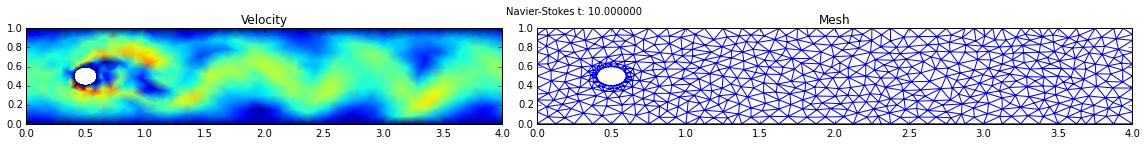

In [8]:
pl, ax = plt.subplots();

# Time-stepping loop
while t < T:
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx + 
         gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
         d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
         
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)
    
    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k
    stepcounter += 1
    u0 = project(u, V)

print "elapsed CPU time: ", (time.clock() - timer0)

#### Computation of Drag Force

We use `psimarker` to mark the region on which we want to compute drag force.

In [15]:
psimarker = [om,im,nm][2]

In [16]:
n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)

In [17]:
# Now we reset:
resolution=30
d = .2*h**(3./2.)
gamma = 10*1./h

drag_force

0.12469880911302475

So it turns out the correct `psimarker` was `nm` defined above as:

`nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)`

#### Drag Force around a Square

Replace the circle with a square with the same center at `(0.5, 0.5)` and side length of `0.1`, ie the square's perimeter is `0.4`. What is the dragforce for `mresolution=50`, `nrefinement=2` ?

In [ ]:
# psimarker = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", 
#                        XMIN=XMIN, XMAX=XMAX, eps=eps)

In [56]:
# Generate domain and mesh
XMIN = 0.
XMAX = 4.
YMIN = 0  # <-- is there a reason int & not float?
YMAX = 1.
G = [XMIN, XMAX, YMIN, YMAX]
eps = 1e-5

mresolution = 20
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), 
                               Point(G[1], G[3])) - Rectangle(Point(.45,.45),
                                                              Point(.55,.55)),
                     mresolution)

In [57]:
# # refinement
# nrefinement=2


# for i in range(0, nrefinement): # Refine mesh
#     cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())

# for c in cells(mesh):
#     p = c.midpoint()
#     cell_markers[c] = (abs(p[0] - .5) < .5 and abs(p[1] - .5) < .3 and c.diameter() > .1) or c.diameter() > .2
# #     cell_markers[c] = (abs(p[0] - 2) <= 2 and abs(p[1] - .5) <= 0.5)

# mesh = refine(mesh, cell_markers)

In [58]:
nrefinement = 2
for i in range(0, nrefinement): # Refine mesh

    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim());

    for c in cells(mesh):

             p_ = c.midpoint()
             cell_markers[c] = (abs(p_[0] - .5) < .5 and abs(p_[1] - .5) < .3 and c.diameter() > .1) or c.diameter() > .2
    mesh = refine(mesh, cell_markers)

In [59]:
# FEM function spaces and functions
V = VectorFunctionSpace(mesh, "CG", 1)
Q = FunctionSpace(mesh, "CG", 1)
W = V * Q
w = Function(W)
h = CellSize(mesh)
u0 = Function(V)
(v, q) = TestFunctions(W)
(u, p) = (as_vector((w[0], w[1])), w[2])

# Inlet Velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX)

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps)
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)

# Timestep, Viscosity, and Stabilization parameters
k = 0.1
nu = 1e-6
d = .2*h**(3./2.)

# Time Interval and Penalty parameter
t, T = 0., 10.
gamma = 10*1./h

# Initialize time stepping
stepcounter = 0
timer0 = time.clock()

# Time stepping method
theta = 0.5

# 0.5 - Midpoint rule
# 1.0 - Implicit Euler
# 0.0 - Explicit Euler

elapsed CPU time:  35.565833


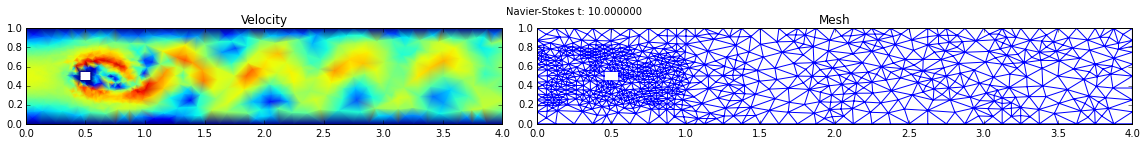

In [60]:
pl, ax = plt.subplots();

# Time-stepping loop
while t < T:
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx + 
         gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
         d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
         
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)
    
    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k
    stepcounter += 1
    u0 = project(u, V)

print "elapsed CPU time: ", (time.clock() - timer0)

I want to only refine the mesh in the vicinity of the square... how

In [61]:
# psimarker = [om,im,nm][2]
psimarker = Expression("x[0]>=0.45-eps && x[0] <= 0.55+eps && x[1]>=0.45-eps && x[1] <= 0.55+eps",eps=1.0e-5 )
# psimarker = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", 
#                        XMIN=XMIN, XMAX=XMAX, eps=eps)

In [62]:
n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)

In [63]:
drag_force

0.0804522151711677

In [64]:
# Now we reset:
resolution=50
d = .2*h**(3./2.)
gamma = 10*1./h

drag_force

0.0804522151711677

In [ ]:
resolution=20
mrefinement=2

In [65]:
p

In [29]:
p

In [40]:
p

In [55]:
p

Ooooookay.. The course said to use resolution of 50.. TA said 20... 50 didnt work, 20 worked. *throws up hands*

---

Some testing of my own:

In [66]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *;
from mshr import *;
from IPython.display import display, clear_output;
import time
import logging;
logging.getLogger('FFC').setLevel(logging.WARNING)

# Compact plot utility function
def plot_compact(u, t, stepcounter):
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u,u)), Q);
        ax.cla();
        fig = plt.gcf();
        fig.set_size_inches(16, 2)
        
        # Plot norm of velocity
        plt.subplot(1, 2, 1)
        mplot_function(uEuclidnorm)
        plt.title("Velocity")
        
        if t == 0:
            plt.colorbar()
            plt.axis(G)
            
        plt.subplot(1,2,2)
        
        if t == 0.:
            plt.triplot(mesh2triang(mesh))
            plt.title("Mesh") # plot mesh
        display(pl) # <-- wait wth is `pl`? Ohh, name defined globally..
        
        plt.suptitle("Navier-Stokes t: %f" % (t))
        plt.tight_layout()
        clear_output(wait=True)

elapsed CPU time:  35.163134


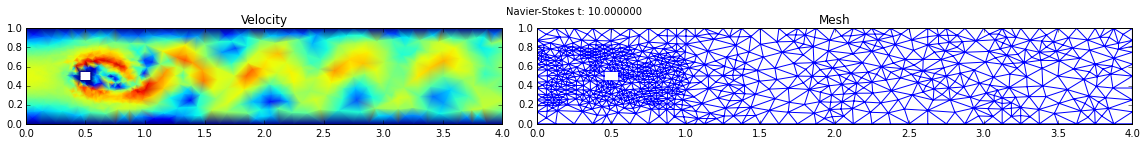

In [67]:
# Generate domain and mesh
XMIN = 0.
XMAX = 4.
YMIN = 0  # <-- is there a reason int & not float?
YMAX = 1.
G = [XMIN, XMAX, YMIN, YMAX]
eps = 1e-5

mresolution = 20
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), 
                               Point(G[1], G[3])) - Rectangle(Point(.45,.45),
                                                              Point(.55,.55)),
                     mresolution)

nrefinement = 2
for i in range(0, nrefinement): # Refine mesh

    cell_markers = MeshFunction("bool", mesh, mesh.topology().dim());

    for c in cells(mesh):
             p = c.midpoint()
             cell_markers[c] = (abs(p[0] - .5) < .5 and abs(p[1] - .5) < .3 and c.diameter() > .1) or c.diameter() > .2
    mesh = refine(mesh, cell_markers)

# FEM function spaces and functions
V = VectorFunctionSpace(mesh, "CG", 1)
Q = FunctionSpace(mesh, "CG", 1)
W = V * Q
w = Function(W)
h = CellSize(mesh)
u0 = Function(V)
(v, q) = TestFunctions(W)
(u, p) = (as_vector((w[0], w[1])), w[2])

# Inlet Velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX)

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps)
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)

# Timestep, Viscosity, and Stabilization parameters
k = 0.1
nu = 1e-6
d = .2*h**(3./2.)

# Time Interval and Penalty parameter
t, T = 0., 10.
gamma = 10*1./h

# Initialize time stepping
stepcounter = 0
timer0 = time.clock()

# Time stepping method
theta = 0.5
        # 0.5 - Midpoint rule
        # 1.0 - Implicit Euler
        # 0.0 - Explicit Euler

pl, ax = plt.subplots();

# Time-stepping loop
while t < T:
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx + 
         gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
         d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
         
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)
    
    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k
    stepcounter += 1
    u0 = project(u, V)

print "elapsed CPU time: ", (time.clock() - timer0)

In [68]:
psimarker = Expression("x[0]>=0.45-eps && x[0] <= 0.55+eps && x[1]>=0.45-eps && x[1] <= 0.55+eps",eps=1.0e-5 )

n = FacetNormal(mesh)
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)

drag_force

0.0804522151711677

In [69]:
p

So uh, looks like taking care not to redefine `p` in the refinement loop doesn't affect anything.

In [70]:
gamma

In [71]:
d

In [74]:
mresolution, resolution

(20, 50)

In [77]:
cell_markers

<dolfin.cpp.mesh.MeshFunctionBool; proxy of <Swig Object of type 'std::shared_ptr< dolfin::MeshFunction< bool > > *' at 0x7f1f80587900> >

In [78]:
cell_avg

<function ufl.operators.cell_avg>